In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from varqus.ode import define_vqs_ode, define_schrodinger_ode
from varqus.integrators import euler
from varqus.states import state_from_parameters, state_infidelity

# Variational Quantum Simulator for the 3 qubits quantum Ising model

For the 3 spins case $n_{s}=3$, and taking the constants $J=B=\frac{1}{2}$, the Hamiltonian becomes:

$$
H = H_{z} + H_{x} = -\frac{1}{2} \left( ZZI + ZIZ + IZZ\right) -\frac{1}{2} \left(XII + IXI + IIX \right)
$$

while the initial state $|\Phi(0)\rangle$ is given by

$$
|\Phi(0)\rangle = CP_{12}(\pi) CP_{23}(\pi) CP_{31}(\pi) H_{1} H_{2} H_{3} |000\rangle
$$

where $H_i$ is the Hadamard gates acting on the $i$ qubit and $CP_{ij}(\pi)$ is gate that induces a $\pi$-phase on the state of the target qubit $j$, depending on the control state $i$.


Following the sames steps as in the 2 qubits simulation, we get the following results

In [2]:
J = 1/2
B = 1/2

# Hamiltonian parameters and operators

hs = [-J, -J, -J, -B, -B, -B]
opsH = ["ZZI", "IZZ", "ZIZ", "XII", "IXI", "IIX"]

# Rotations parameters and operators

fs = [[-1j*J, -1j*J, -1j*J], [-1j*B, -1j*B, -1j*B]]
ops = [["ZZI", "IZZ", "ZIZ"], ["XII", "IXI", "IIX"]]

# Initial state

ini_state = np.array([0.35355339,  0.35355339, 0.35355339, -0.35355339,
                   0.35355339, -0.35355339, -0.35355339, -0.35355339]) + 1j*0

# Normalize state

ini_state = ini_state/np.linalg.norm(ini_state)

In [3]:
# Time discretization and initial parameters for the trial state

params_init = np.array([1.0, 1.0])
dt = 0.01
Nt = 100

Now, we execute our algorithm, first defining the ordinary diferential equation using the variational quantum simulator, and then solving it using a numerical Euler's method, to obtain the parameters in a posterior time $\left\{\lambda_{k}\left(t_{n}\right)\right\}$.

In [4]:
# Define the ode as a function of the parameters

ode = define_vqs_ode(ops, opsH, fs, hs, ini_state, shots=2**13)

# Integrate in time using Euler's method
lambda_k_t = euler(ode, params_init, dt, Nt)


# If you don't want to run the full algorithm, an example is attached on the file "params_2qubits.hdf5".
# Comment the two previous line and uncomment the last two lines

# Save simulated parameters

# params_sim = h5py.File("data/params_3qubits.hdf5", "w")
# dset = params_sim.create_dataset("params", np.shape(lambda_k_t), data=lambda_k_t)
# params_sim.close()

# Load simulated parameters

# params_sim = h5py.File('data/params_3qubits.hdf5', 'r')
# lambda_k_t = params_sim["params"][:]

Text(0.5, 1.0, 'Parameter Evolution using the Variational Quantum Simulator')

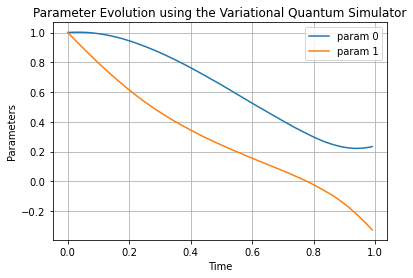

In [5]:
# Plot parameter evolution

plt.plot(dt*np.arange(Nt), lambda_k_t, label = [f"param {i}" for i in range(lambda_k_t.shape[1])])
plt.xlabel("Time")
plt.ylabel("Parameters")
plt.legend(loc="best")
plt.grid()
plt.title("Parameter Evolution using the Variational Quantum Simulator")

In [6]:
initial_state_s = state_from_parameters(params_init, ops, fs, ini_state)

In [7]:
# Solve the schrodinger equation numerically

schrodinger = define_schrodinger_ode(opsH, hs)
numeric_evolution = euler(schrodinger, initial_state_s, dt, Nt)

Text(0.5, 1.0, 'Infidelity between the obtained state from the VQS and the Schrödinger evolution')

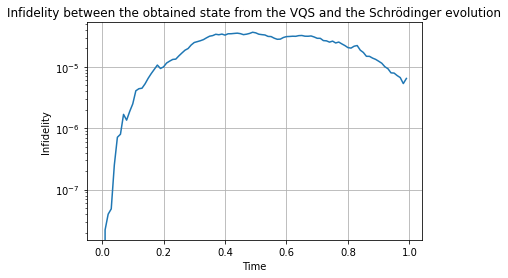

In [8]:
# From params to the state psi(lambda)

psi_lambda_t = [state_from_parameters(lambda_k_t[t], ops, fs, ini_state) for t in range(Nt)]

# Calculate infidelity from the circuit vqs with the schrodinger equation solution using matrix exponentiation

inf_array = [state_infidelity(numeric_evolution[t], psi_lambda_t[t]) for t in range(Nt)]

plt.plot(dt*np.arange(Nt), inf_array)
plt.xlabel("Time")
plt.ylabel("Infidelity")
plt.yscale("log")
plt.grid()
plt.title("Infidelity between the obtained state from the VQS and the Schrödinger evolution")